### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [3]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

dataframe = dataframe.tail(515)

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (43800, 7)
dataframe shape (43800, 7)


,pollution,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,,
2014-12-10 13:00:00,62.0,-17.0,5.0,1025.0,32.62,0.0,0.0
2014-12-10 14:00:00,45.0,-19.0,5.0,1026.0,43.80,0.0,0.0
2014-12-10 15:00:00,19.0,-19.0,5.0,1026.0,53.63,0.0,0.0
2014-12-10 16:00:00,21.0,-18.0,4.0,1027.0,61.68,0.0,0.0
2014-12-10 17:00:00,13.0,-18.0,2.0,1028.0,70.62,0.0,0.0


In [4]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,pollution,dewp,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.732925,-0.225420,-0.331618,-0.447500,nan,nan
dewp,0.732925,1.000000,-0.088796,-0.342237,-0.618074,nan,nan
temp,-0.225420,-0.088796,1.000000,-0.295625,-0.081949,nan,nan
press,-0.331618,-0.342237,-0.295625,1.000000,0.346173,nan,nan
wnd_spd,-0.447500,-0.618074,-0.081949,0.346173,1.000000,nan,nan
snow,nan,nan,nan,nan,nan,nan,nan
rain,nan,nan,nan,nan,nan,nan,nan


### Test Train split

train_xy and test_xy size: (500, 7), (15, 7)

y_train and x_train size (500,), (500, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

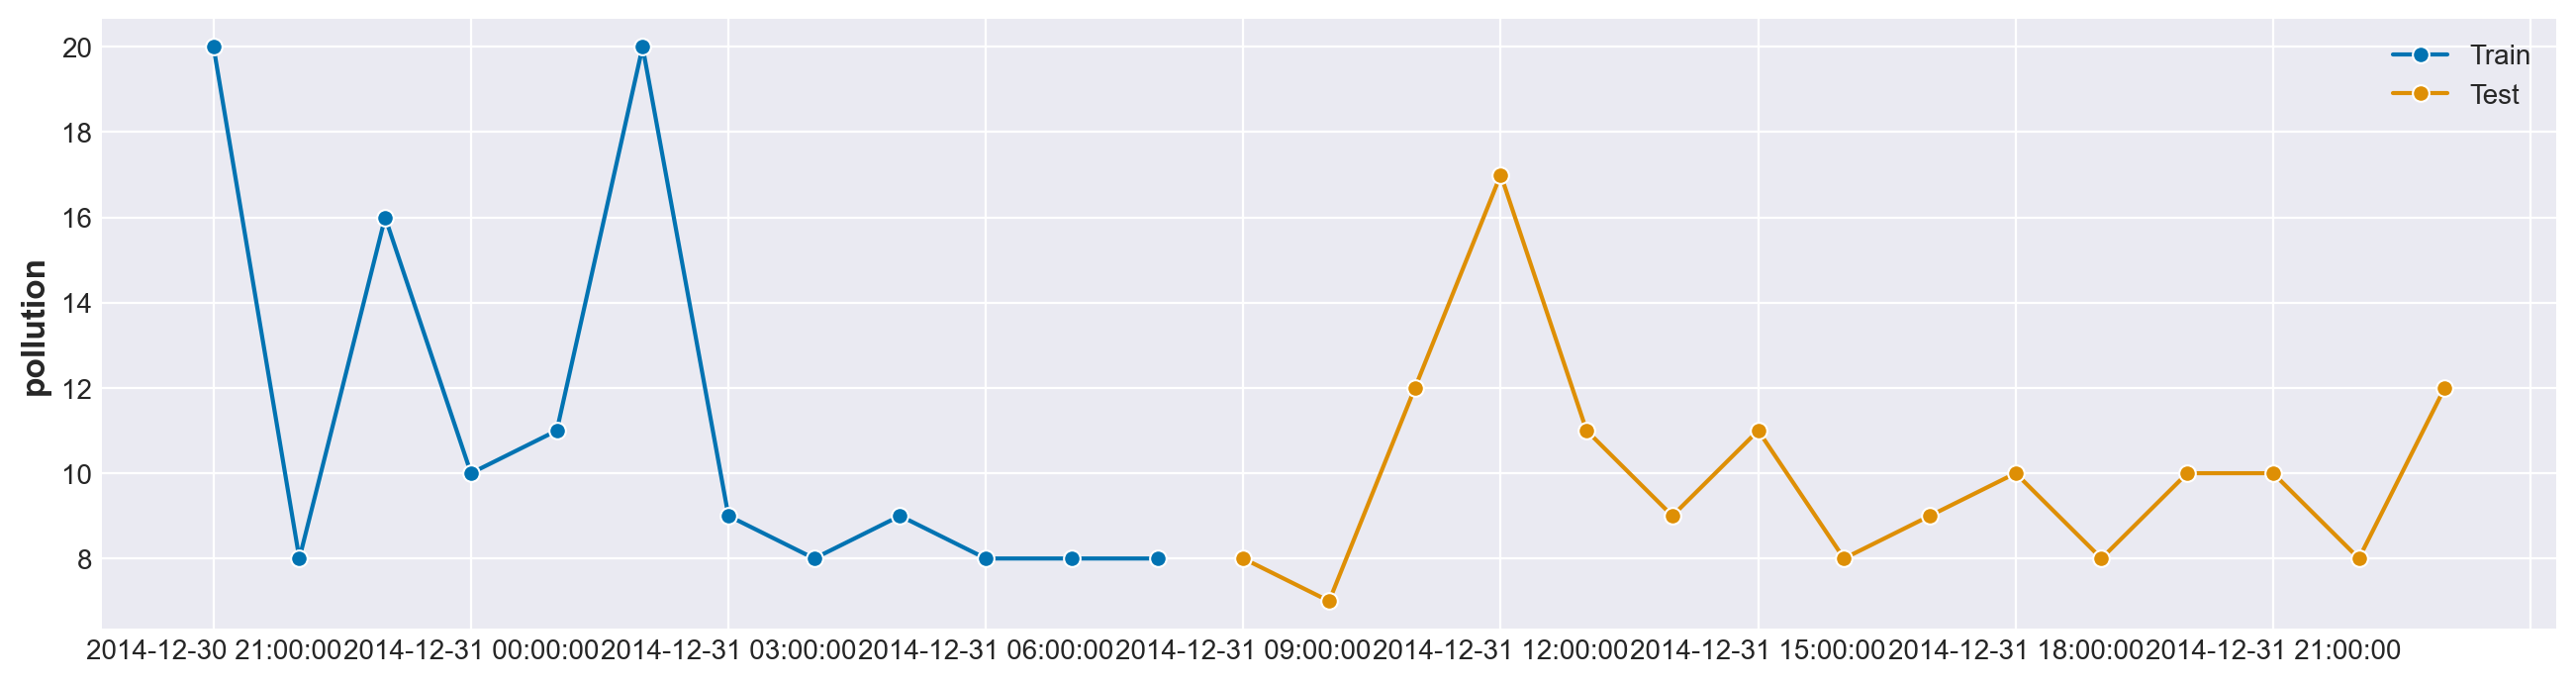

In [5]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "pollution"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

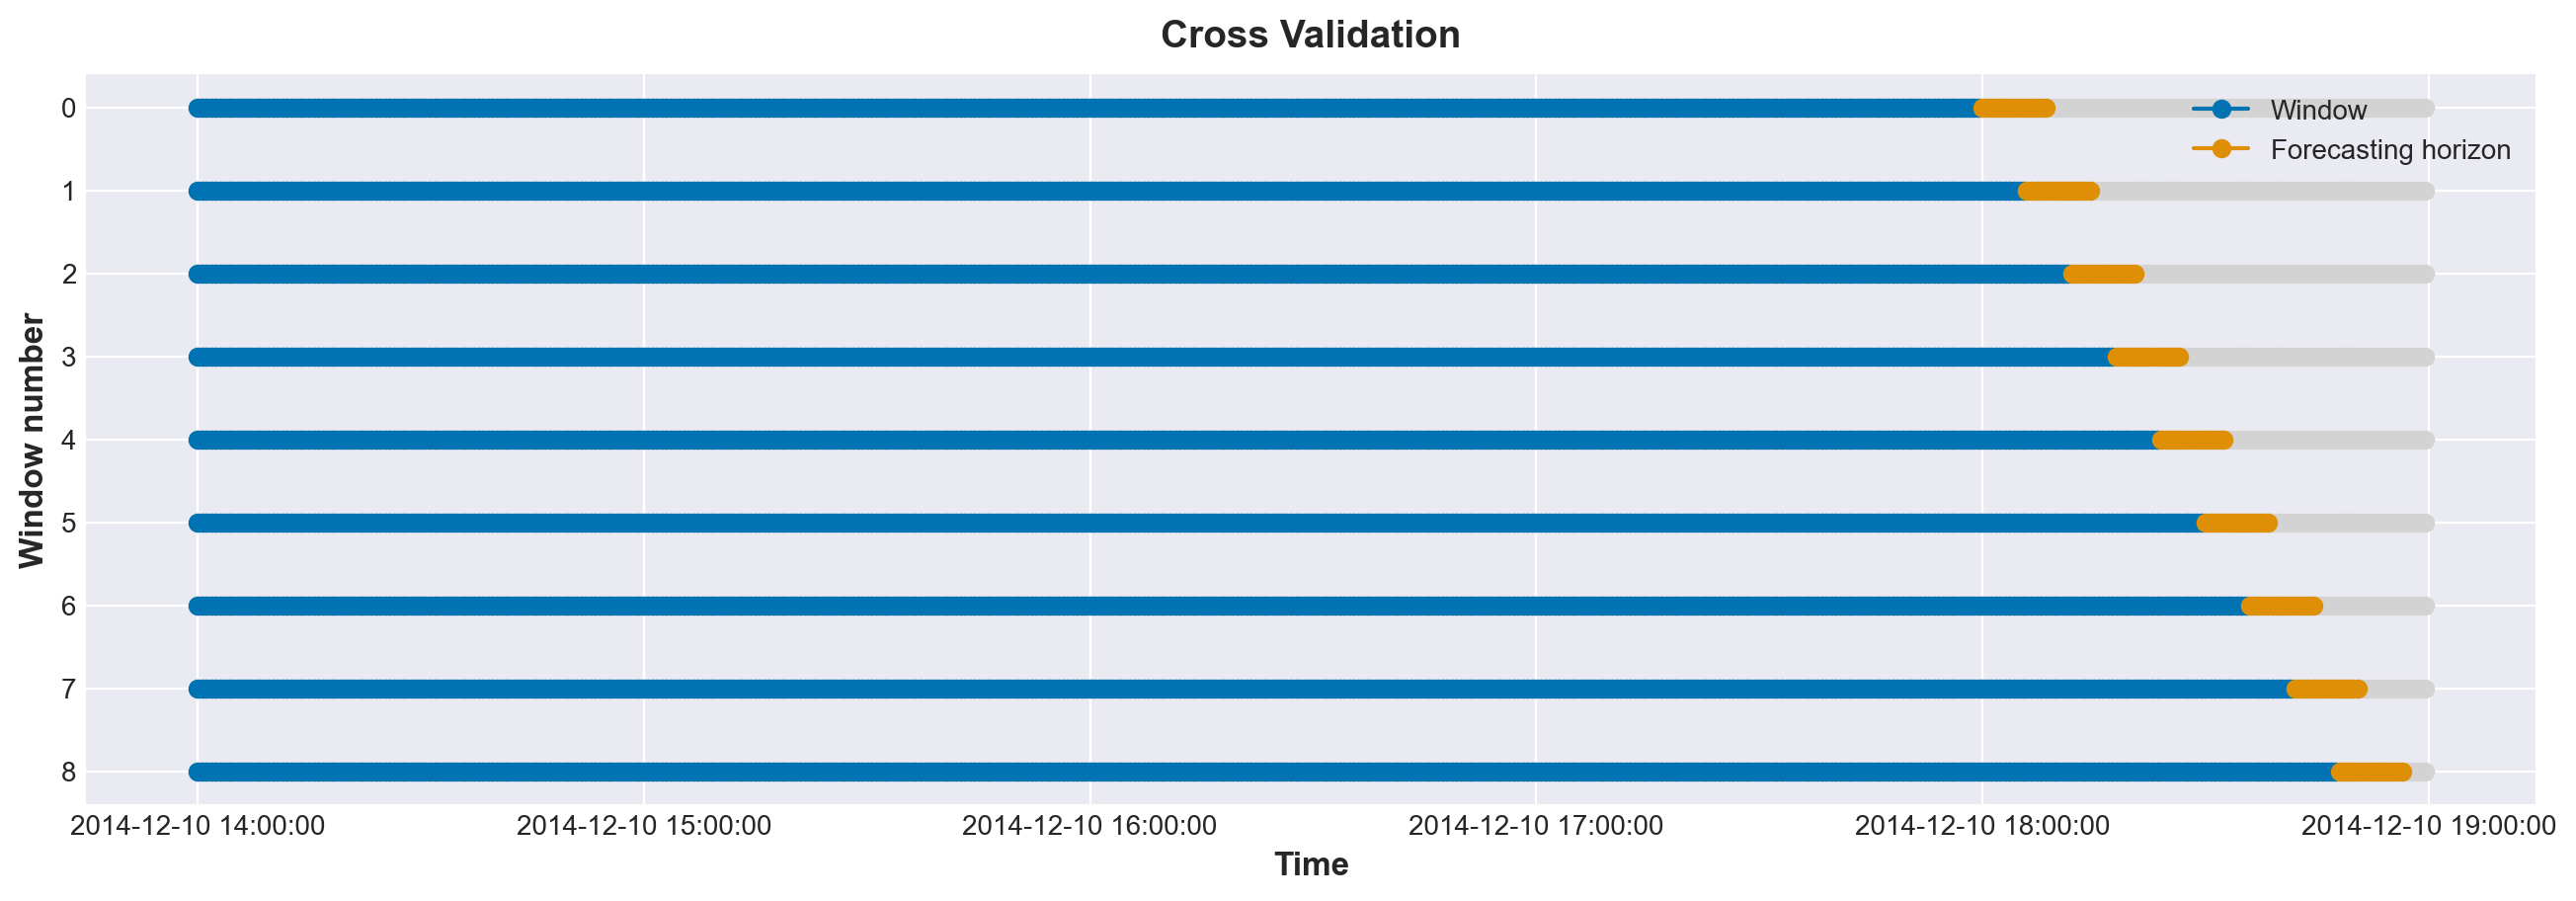

In [6]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

intital_window_size = int(y_train.shape[0] * 0.80)

cv = ExpandingWindowSplitter(fh, initial_window=intital_window_size, step_length=10)

plot_windows(cv, y_train, title="Cross Validation")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

param_grid = {
    "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "forecaster__deseasonalizer__sp": [24, 48],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [10],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        ("scaler_x", TabularToSeriesAdaptor(MinMaxScaler())),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=LinearRegression(),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

intital_window_size = int(y_train.shape[0] * 0.80)

cv = ExpandingWindowSplitter(fh, initial_window=intital_window_size, step_length=10)

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsolutePercentageError(symmetric=True),
    cv=cv,
    param_grid=param_grid,
    verbose=1,
    n_jobs=1,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best Params", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Fitting 9 folds for each of 16 candidates, totalling 144 fits


In [ ]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [ ]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

### Backtesting Insample Prediction

In [ ]:
from sktime.forecasting.model_evaluation import evaluate

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=MeanAbsolutePercentageError(symmetric=False),
    return_data=True,
)
results

In [ ]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [ ]:
gscv.best_forecaster_.get_fitted_params()

### Train Model Parameter

In [ ]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
# model_fname_in = gscv.best_forecaster_.get_fitted_params()['forecaster__reducer__estimator__feature_names_in']
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
# print(f'model_fname_in {model_fname_in}', end='\n\n')
print(f"model_fname_in {model_coeff}", end="\n\n")
print(f"model_fname_in {model_intercept}", end="\n\n")

### model cutoff

In [ ]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

### Model saving 

In [ ]:
import joblib

joblib.dump(gscv.best_forecaster_, "./model_1.joblib")

### Features importance

In [ ]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)